# LAB 3: Prognosis and survival functions

In this lab, we will analyze observations from different patients who suffered advanced cancer and we will create different survival functions employing univariate (Kaplan-Meier estimate) and multivariate (CPH and Extra Survival Trees) analysis.

Remember to copy this notebook into your personal folder and suffix your JHID:


*   eg: Lab3_Prognosis_jmei10

Please always emember to use the MLMA coding rubric.


In [3]:
# Libraries to be used in this lab. Feel free to add more libraries if you need them
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install lifelines
from lifelines import CoxPHFitter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#!pip uninstall scikit-learn
!pip install xlrd
!pip install scikit-survival
from sksurv.ensemble import ExtraSurvivalTrees
from sksurv.preprocessing import OneHotEncoder
import xlrd
import zipfile
# If error '...ContextualVersionConflict...' occurs, uninstall your 'scikit-learn' and restart the runtime.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached scikit_learn-1.1.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (31.2 MB)


**DATA**

The data that we are going to use in this lab is described in the paper ["Performance of clinician prediction of survival in oncology outpatients with advanced cancer"](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0267467). According to the authors: 

*A total of 200 advanced cancer patients were enrolled and the median overall survival was 7.6 months... This study was part of a prospective cohort study aimed at developing a prognostic model in medical oncology outpatients... The prognostic model predicts 3-month survival to facilitate palliative care referral at least 3 months before death. We enrolled advanced cancer patients treated at a comprehensive cancer center of a university hospital from March 2016 to January 2019. Patients were eligible if they had a diagnosis of advanced cancer, when their oncologists estimated their survival to be less than a year and were 18 years or older. We defined advanced cancer as a metastatic or recurrent disease or progressive locally advanced disease not amenable to curative treatment. Patients were excluded if they had hematologic malignancies, were expected to survive less than a month, and were not able to communicate. Written informed consent was obtained from each patient before enrollment. The protocol was approved by the Institutional Review Board (IRB) of Seoul National University Bundang Hospital (IRB number: B-1601/332-302).*

You can find this data in this link:[LINK](https://plos.figshare.com/articles/dataset/S1_Data_-/19631638?backTo=/collections/Performance_of_clinician_prediction_of_survival_in_oncology_outpatients_with_advanced_cancer/5957779)

For univariate analysis, we will assume that the authors of the dataset had an appropriate criteria for t=0.

In [4]:
#Load  the data
#Please load the processed data from the drive link below, as the original file has some encoding issues
sData='https://docs.google.com/spreadsheets/d/1ObVvB7ofWPe-7xZWpAq5MGDaTrV651F9T21ZsoAB-VM/export?format=csv'
urllib.request.urlretrieve(sData,'./advance_cancer.csv')
df=pd.read_csv('./advance_cancer.csv')

In [5]:
# Visualize the data (showing a part of the csv form) and obtain statistics (number of observations and variables)
print('Number of observations: ', len(df))
print('Number of variables (not all are predictors): ', len(df.columns)-2)
df.tail()

Number of observations:  200
Number of variables (not all are predictors):  106


,Study_No,Sex,Age,SurvivalTime,SurvivalTimeW,ST_12,ST_24,ST_36,ST_48,ST_52,...,QLQC_SF,QLQC_FA,QLQC_NV,QLQC_PA,QLQC_DY,QLQC_SL,QLQC_AP,QLQC_CO,QLQC_DI,QLQC_FI
195,197,1,71,113,16.142857,0,1,1,1,1,...,100.000000,22.222222,0.000000,33.333333,66.666667,0.000000,33.333333,0.000000,0.0,0.000000
196,198,1,78,321,45.857143,0,0,0,1,1,...,50.000000,22.222222,0.000000,33.333333,0.000000,0.000000,0.000000,33.333333,0.0,66.666667
197,199,1,61,323,46.142857,0,0,0,1,1,...,83.333333,22.222222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
198,200,1,57,469,67.000000,0,0,0,0,0,...,50.000000,11.111111,16.666667,33.333333,66.666667,33.333333,33.333333,33.333333,0.0,66.666667
199,201,1,77,267,38.142857,0,0,0,1,1,...,33.333333,33.333333,0.000000,0.000000,0.000000,33.333333,0.000000,66.666667,0.0,33.333333


# 0. Check your data

Task 1: Please check the gender and age distribution of the dataset (3 POINTS)

128

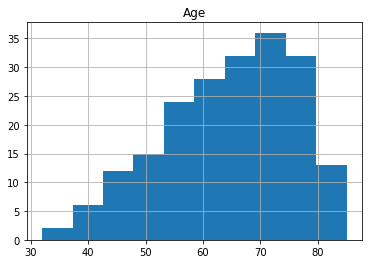

In [7]:
# Please plot a histogram of the AGE distribution:

# YOUR CODES GO HERE
df.hist(column="Age")

# and answer a question briefly：how many male patients (Sex: 1) are in this dataset? 

# YOUR CODES GO HERE
sum(df["Sex"]==1)  
# There are 128 male patients that appear in the dataset

**TASK 2:** Do you think the dataset we are using is age and gender balanced? Why or why not? Please comment your opinions below. (2 POINT)

No, I do not think that our dataset is balanced. We saw for those patients whose data is recorded in this dataset, the majority of them are male and aged. 

# 1. Prognostic Model

Different from survival models, prognostic models try to answer questions referred to  fixed period or related to a certain event. 

The EORTC Core Quality of Life questionnaire (EORTC QLQ-C30) is designed to measure cancer patients' physical, psychological and social functions [LINK](https://www.eortc.org/app/uploads/sites/2/2018/02/SCmanual.pdf). And according to the [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7160394/#:~:text=The%20QLQ%E2%80%90C30%20summary%20score,score%20indicating%20a%20better%20HRQoL.), QLQ‐C30 summary score was the strongest predictor of all‐cause mortality.

Before working on the survival models, let's first try to check if we could construct a prognostic model.

In [8]:
# Maintain the columns of interest only.
df_prognostic = pd.DataFrame();
df_prognostic['Termination_Situation'] = df['Termination_Situation'];
df_prognostic['SurvivalTime'] = df['SurvivalTime'];
df_prognostic['Censored'] = df['Censored'];
df_prognostic['Age'] = df['Age'];
# assign values for some selected predictors
df_prognostic['QLQC_sum' ] = df['QLQC_QL2' ] 
QLQC_scores  = ['PF2','RF2','EF','CF','SF','FA','NV','PA','DY','SL','AP','DI']
for i in QLQC_scores:  
  df_prognostic['QLQC_sum'] += df['QLQC_' + i ]
df_prognostic['QLQC_sum'] = df_prognostic['QLQC_sum']/13
df_prognostic_no_3=df_prognostic[~df_prognostic['Termination_Situation'].isin([3])]
df_prognostic   = df_prognostic_no_3

**TASK 3:** To build the prognostic model, we should always delete the censored data ('Censored' = 1). Please expain why. (4 POINT)


Censored data means some parts of the observation are unobserved. i.e. some of entries in our dataset are missing. Therefore, we usually want to delete the censored data since we can't train a model with partially observed data.

**TASK 4:** Junhua is planing to train a logistic regression model for df_prognostic['QLQC_sum']&df_prognostic['Age'] vs df_prognostic['Termination_Situation'] just like in the [example figure](https://static.javatpoint.com/tutorial/machine-learning/images/logistic-regression-in-machine-learning14.png). Can he do it successfully for this set of data, after deleting all the censored samples? (1 POINT)


In [36]:
from sklearn.linear_model import LogisticRegression# 
# data preparation
Xtrain = np.array( [df_prognostic['QLQC_sum'],df_prognostic['Age']]);
Ytrain = np.array( [df_prognostic['Termination_Situation']]).squeeze(); 
# standardlization
std = StandardScaler()  
Xtrain = std.fit_transform(Xtrain)
Xtrain = Xtrain.transpose()

# YOUR CODES GO HERE, no need to run the logistic regression. HINTS: try to remove the censored data.
pd.DataFrame(Ytrain)[(df_prognostic["Censored"]==1).reset_index(drop=True)]

,0
35,1
47,1
53,1
60,1
64,1
67,1
68,1
72,1
74,1
77,1


No, he will not be able to train a logistic regression model if he delete all the censored data. As you can see from the dataframe printed above, one we delete all censored data, the dataset only contains 1 class, which is "1" only. The model trained upon the given data will not have predictive power over the class other than "1"

# 2. Univariate analysis: Univariate survival functions and cumulative hazard


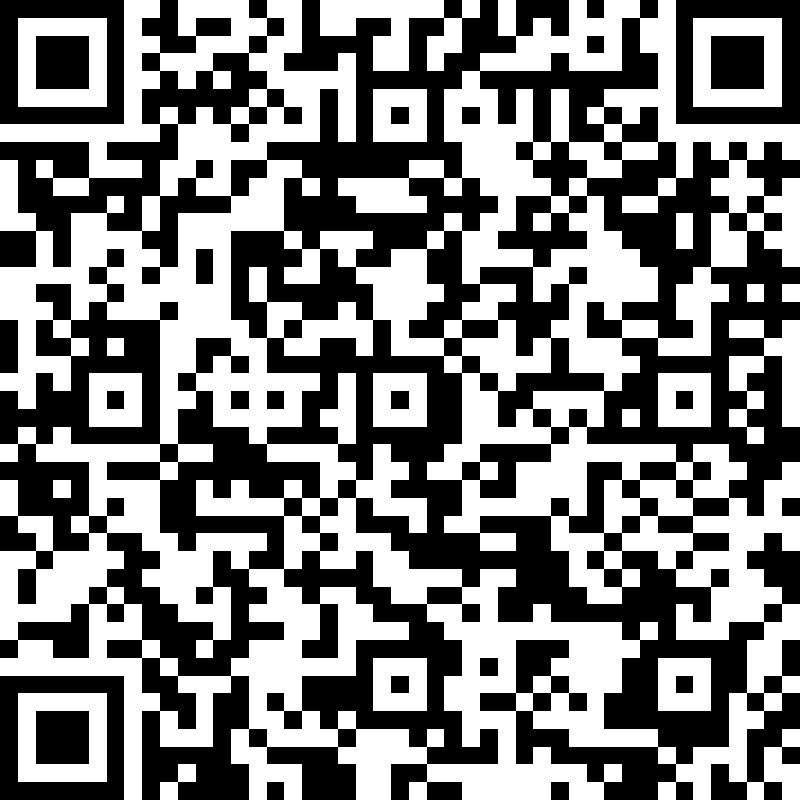


**TASK 5:** Calculate and plot the survival function employing the Kaplan-Meier estimate  (10 POINTS)

In [93]:
# Calculate and plot the survival function employing the Kaplan-Meier estimate
def calculate_survival_KM(df, TimeColumn, EventColumn, EVENT_HAPPEN_INDICATOR, EVENT_NOT_HAPPEN_INDICATOR):
  """
Generates a dataframe containing the survival function (time vs probability of survival)
employing the Kaplan-Meier estimate.
Inputs: 
      df: input dataframe
      TimeColumn: name of the colum containing the event time
      EventColumn: name of the column indicating if the event happened HAPPEN_INDICATOR or not NOT_HAPPEN_INDICATOR
      EVENT_HAPPEN_INDICATOR: the indicator status when event happens, like 2 for death
      EVENT_NOT_HAPPEN_INDICATOR: the indicator status when event does not happen, like 1 for alive
Outputs:
      dfSurv: dataframe containing the time and probability of survival
  """
  # YOUR CODES GO HERE

  selected_df=df[[TimeColumn,EventColumn]]

  survival_time=[]
  survival_probability=[]

  for i in list(df[TimeColumn]):
    cumulative_product=1
    for j in range(i):
      # Compute how many people died at time J and compute the comulative product 
      if sum(df[TimeColumn]==j)!=0:
        patients_at_j=selected_df[df[TimeColumn]==j]
        number_died_at_j=sum(patients_at_j[EventColumn]==EVENT_HAPPEN_INDICATOR)
        # Check number of patients who survive at time j 
        number_survive_after_j=sum(df[TimeColumn]>j)
        number_survive_at_j=sum(patients_at_j[EventColumn]==EVENT_NOT_HAPPEN_INDICATOR)
        denominator=number_survive_after_j+number_survive_at_j
        # Computer the term product 
        product=1-(number_died_at_j/denominator)
        cumulative_product=cumulative_product*product
    survival_probability.append(cumulative_product)
    survival_time.append(i)

  out_dataframe=pd.DataFrame([survival_time,survival_probability]).transpose()

  return out_dataframe
  

def plot_survival(df, TimeColumn, EventColumn, Name, EVENT_HAPPEN_INDICATOR, EVENT_NOT_HAPPEN_INDICATOR):
  """
  This function plots the survival function of the whole df. This function calls
  calculate_survival_KM.
  Inputs: 
      df: input dataframe
      TimeColumn: name of the colum containing the event time
      EventColumn: name of the column indicating if the event happened HAPPEN_INDICATOR or not NOT_HAPPEN_INDICATOR
      Name: legend to be displayed, associated to the survival function
      EVENT_HAPPEN_INDICATOR: the indicator status when event happens, like 2 for death
      EVENT_NOT_HAPPEN_INDICATOR: the indicator status when event does not happen, like 1 for alive

  """
  # YOUR CODES GO HERE
  
  out=calculate_survival_KM(df, TimeColumn, EventColumn, EVENT_HAPPEN_INDICATOR, EVENT_NOT_HAPPEN_INDICATOR)

  out=out.sort_values(0)


  plt.plot(out[0],out[1])
  plt.legend([Name])
  plt.show()


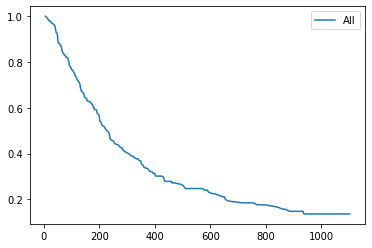

In [94]:
## HINTs: Please USE SurvivalTime rather than SurvivalTimeW
# Plot the survival function obtained with the whole dataframe
TimeColumn='SurvivalTime'
EventColumn='Termination_Situation'
plot_survival(df, TimeColumn, EventColumn, 'All', 2, 1)

**TASK 6:** Code a function that displays the survival function of two categories of a certain predictor (eg. male, female) in the same plot (10 POINTS).

In [100]:
# function to print two categories 
def plot_survival_twocat(df, predictor, cat1, cat0,cat1_name, cat0_name ):
  """
  Displays the survival function of two categories of a certain predictor 
  (eg. smoker and non-smoker or male, female) in the same plot. This function
  only considers binary categories: 0 and 1.
  Inputs:
        df: input dataframe
        predictor: column containing the predictor variable that we want to study
        cat1: Label of the category associated to One category (eg. '1')
        cat0: Label of the category associated to The other category (eg. '2')
        cat1_name: real name for cat1's label (eg. 'Male')
        cat0_name: real name for cat1's label (eg. 'Female')
  """
  # YOUR CODES GO HERE

  df1=df[df[predictor]==cat1]
  df2=df[df[predictor]==cat0]

  out1=calculate_survival_KM(df1, 'SurvivalTime','Termination_Situation', 2, 1)
  out1=out1.sort_values(0)
  plt.plot(out1[0],out1[1])


  out2=calculate_survival_KM(df2, 'SurvivalTime','Termination_Situation', 2, 1)
  out2=out2.sort_values(0)
  plt.plot(out2[0],out2[1])
  plt.legend([cat1_name,cat0_name])


  plt.show()

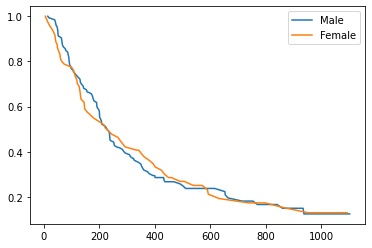

In [101]:
# Plot survival for male vs female
predictor='Sex'
cat1=1; cat0=2
cat1_name = 'Male'; cat0_name = 'Female';
plot_survival_twocat(df, predictor, cat1, cat0,cat1_name,cat0_name ) 

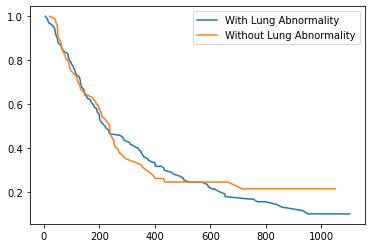

In [102]:
# Plot survival for Diagnosis_Lung_A
predictor='Diagnosis_Lung_A'
cat1=0 ; cat0=1;
cat1_name = 'With Lung Abnormality'; cat0_name = 'Without Lung Abnormality';
plot_survival_twocat(df, predictor, cat1, cat0,cat1_name,cat0_name ) 

Which factor above poses a stronger influence on the survival？ 

From the two graphs above, we can see that the factor "lung abnormality" has greater influence on patient's chance of survival since two lines are not closely fit together in plot2 . 

**TASK 7:** Plot the cumulative Hazard using the Nelson-Aalen estimator (10 Points)

In [103]:
# Plot the cumulative Hazard using the Nelson-Aalen estimator
def cumulative_hazard_NA(df, TimeColumn, EventColumn, EVENT_HAPPEN_INDICATOR, EVENT_NOT_HAPPEN_INDICATOR):
  """
  Generates a dataframe containing the cumulative hazard  (H(t) employing the 
  Nelson-Aalen estimator.
  Inputs: 
        df: input dataframe
        TimeColumn: name of the colum containing the event time
        EventColumn: name of the column indicating if the event happened or not
        EVENT_HAPPEN_INDICATOR: the indicator status when event happens, like 2 for death
        EVENT_NOT_HAPPEN_INDICATOR: the indicator status when event does not happen, like 1 for being alive
  Outputs:
        dfH: dataframe containing the time and Cumulative Hazard (H(t))
  """

  # YOUR CODES GO HERE
  
  selected_df=df[[TimeColumn,EventColumn]]

  survival_time=[]
  survival_probability=[]

  for i in list(df[TimeColumn]):
    cumulative_sum=0
    for j in range(i):
      # Compute how many people died at time J and compute the comulative product 
      if sum(df[TimeColumn]==j)!=0:
        patients_at_j=selected_df[df[TimeColumn]==j]
        number_died_at_j=sum(patients_at_j[EventColumn]==EVENT_HAPPEN_INDICATOR)
        # Check number of patients who survive at time j 
        number_survive_after_j=sum(df[TimeColumn]>j)
        number_survive_at_j=sum(patients_at_j[EventColumn]==EVENT_NOT_HAPPEN_INDICATOR)
        denominator=number_survive_after_j+number_survive_at_j
        # Compute the sum 
        h_t=(number_died_at_j/denominator)
        cumulative_sum=cumulative_sum+h_t
    survival_probability.append(cumulative_sum)
    survival_time.append(i)

  out_dataframe=pd.DataFrame([survival_time,survival_probability]).transpose()

  return out_dataframe

def plot_cumH(df, TimeColumn, EventColumn, Name,EVENT_HAPPEN_INDICATOR, EVENT_NOT_HAPPEN_INDICATOR):
  """
  This function plots the cumulative hazard of the whole df. This function calls
  calculate_hazard_NA.
  Inputs: 
      df: input dataframe
      TimeColumn: name of the colum containing the event time
      EventColumn: name of the column indicating if the event happened 
      Name: legend to be displayed, associated to the CH
      EVENT_HAPPEN_INDICATOR: the indicator status when event happens, like 2 for death
      EVENT_NOT_HAPPEN_INDICATOR: the indicator status when event does not happen, like 1 for being alive
  """

  # YOUR CODES GO HERE

  out=cumulative_hazard_NA(df, TimeColumn, EventColumn, EVENT_HAPPEN_INDICATOR, EVENT_NOT_HAPPEN_INDICATOR)

  out=out.sort_values(0)


  plt.plot(out[0],out[1])
  plt.legend([Name])
  plt.show()


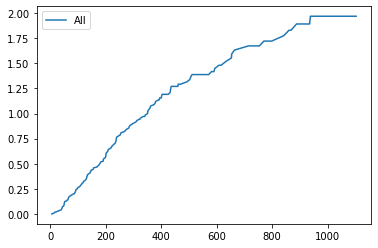

In [104]:
# Plot the cumulative hazard of df
TimeColumn='SurvivalTime'
EventColumn='Termination_Situation'
plot_cumH(df, TimeColumn, EventColumn, 'All', 2, 1)

# 2. Multivariate analysis
**Cox Proportional Hazards**

Now, we are going to employ multivariate analysis using CPH to determine the survival funtions and the hazard ratio of different patients. 
We will employ [lifelines](https://lifelines.readthedocs.io/en/latest/index.html), a python survival analysis library.

In [105]:
# Before doing CPH analysis, let us first pick up the predictors from all the variables, as most of them are actually analysis results.
df_cph = pd.DataFrame();
df_cph['Termination_Situation'] = df['Termination_Situation'];
df_cph['SurvivalTime'] = df['SurvivalTime'];
# assign values for some selected predictors
predictors = ['Sex','Age','Oncologist_gr','Diagnosis_Lung_A','Diagnosis_Stomatch_A','TE_RadiationTherapy','TE_immunoTherapy','TE_HormoneTherapy','Diagnosis_ColonRectal_A',	'Diagnosis_OvaryCervial_A',	'Diagnosis_LiverBiliarytract_A',	'Diagnosis_Pancreas_A',	'Diagnosis_Esophagus_A',	'Diagnosis_Headandneck_A',	'Diagnosis_Softtissue_A',	'Diagnosis_KidneyBlandder_A']
for predictor in predictors:  
  df_cph[predictor] = df[predictor]

In [106]:
!pip install lifelines
from lifelines import CoxPHFitter 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**TASK 8:** divide the dataframe into training and testing subsets and normalize the data. (5 POINTS).

In [356]:
#Divide the data into training -dfTrain- (80%), and testing -dfTest- (20%):

# YOUR CODES GO HERE

X_train, X_test = train_test_split(df_cph, test_size=0.2)


for i in X_train.columns:
  if i!="Termination_Situation":
    X_train[i]=(X_train[i]-X_train[i].mean())/X_train[i].std()
    X_test[i]=(X_test[i]-X_test[i].mean())/X_test[i].std()

X_train=X_train.fillna(0.001)
X_test=X_test.fillna(0.001)

**TASK 9:** Calculate and print the Cox proportional hazards coefficients of the training subset (dfTrain). As the data was normalized, the coefficients will provide information about the effect size of the predictor variables (5 POINTS).

In [244]:
# Calculate and print the Cox proportional hazards coefficients

# YOUR CODES GO HERE

cph = CoxPHFitter()
cph.fit(X_train,duration_col="SurvivalTime",event_col="Termination_Situation")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 160 total observations, 0 right-censored observations>
             duration col = 'SurvivalTime'
                event col = 'Termination_Situation'
      baseline estimation = breslow
   number of observations = 160
number of events observed = 160
   partial log-likelihood = -638.14
         time fit was run = 2023-02-19 03:12:37 UTC

---
                                coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                             
Sex                            -0.11       0.89       0.10            -0.31             0.08                 0.73                 1.09
Age                             0.00       1.00       0.09            -0.18             0.18                 0.84                 1.20
Oncologist_gr                  -0.09       0.92       0.12            -0.32             0.14                 0.73                 1.15
Diagnosis_Lung_A                0.07       1.08       0.11            -0.14             0.29                 0.87                 1.33
Diagnosis_Stomatch_A            0.28       1.32       0.11             0.07             0.49                 1.07                 1.63
TE_RadiationTherapy             0.15       1.16       0.09            -0.02             0.32                 0.98                 1.38
TE_immunoTherapy               -0.12       0.89       0.08            -0.28             0.04                 0.75                 1.04
TE_HormoneTherapy              -0.03       0.97       0.09            -0.22             0.15                 0.80                 1.17
Diagnosis_ColonRectal_A         0.05       1.05       0.09            -0.12             0.23                 0.88                 1.26
Diagnosis_OvaryCervial_A        0.10       1.11       0.09            -0.07             0.27                 0.93                 1.31
Diagnosis_LiverBiliarytract_A   0.17       1.19       0.09             0.00             0.34                 1.00                 1.41
Diagnosis_Pancreas_A           -0.20       0.82       0.12            -0.43             0.03                 0.65                 1.03
Diagnosis_Esophagus_A           0.02       1.02       0.08            -0.15             0.18                 0.86                 1.20
Diagnosis_Headandneck_A         0.01       1.01       0.09            -0.17             0.19                 0.84                 1.21
Diagnosis_Softtissue_A         -0.16       0.86       0.09            -0.34             0.03                 0.71                 1.03
Diagnosis_KidneyBlandder_A     -0.13       0.88       0.11            -0.34             0.08                 0.71                 1.08

                                cmp to     z    p   -log2(p)
covariate                                                   
Sex                               0.00 -1.13 0.26       1.96
Age                               0.00  0.00 1.00       0.00
Oncologist_gr                     0.00 -0.75 0.46       1.13
Diagnosis_Lung_A                  0.00  0.68 0.49       1.02
Diagnosis_Stomatch_A              0.00  2.59 0.01       6.71
TE_RadiationTherapy               0.00  1.71 0.09       3.52
TE_immunoTherapy                  0.00 -1.48 0.14       2.84
TE_HormoneTherapy                 0.00 -0.34 0.74       0.44
Diagnosis_ColonRectal_A           0.00  0.59 0.55       0.85
Diagnosis_OvaryCervial_A          0.00  1.16 0.25       2.02
Diagnosis_LiverBiliarytract_A     0.00  2.00 0.05       4.47
Diagnosis_Pancreas_A              0.00 -1.67 0.09       3.41
Diagnosis_Esophagus_A             0.00  0.19 0.85       0.24
Diagnosis_Headandneck_A           0.00  0.09 0.93       0.11
Diagnosis_Softtissue_A            0.00 -1.66 0.10       3.36
Diagnosis_KidneyBlandder_A        0.00 -1.22 0.22       2.17
---
Concordance = 0.63
Partial AIC = 1308.28
log-likelihood ratio test = 34.69 on 16 df
-log

**TASK 10:** Plot the survival function of the three first participants in the test subset (5 POINTS).

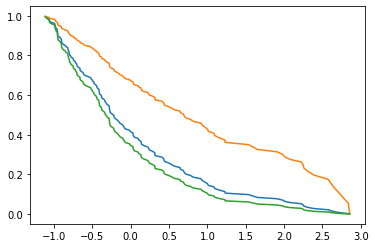

In [248]:
# Plot the survival function of the three first participants in the test subset
participant1=0
participant2=1
participant3=2

# YOUR CODES GO HERE
plt.plot(cph.predict_survival_function(X_test.iloc[0,:]))
plt.plot(cph.predict_survival_function(X_test.iloc[1,:]))
plt.plot(cph.predict_survival_function(X_test.iloc[2,:]))
plt.show()

As you could observe, they are 'proportional'.

**TASK 11:** Create a function that calculates the hazard ratio between two patients. This will tell us which of the two patients is at a higher risk (10 POINTS).

In [267]:
# Create a function that calculates the hazard ratio between two patients. This will tell us which patient is at a higher risk.
def hazard_ratio(df, participant1, participant2, cph):
    '''
    Calculates the hazard ratio of participant1 vs participant 2 using
    the coefficients of the CPH model.
    
    Inputs:
        df: dataframe containing all the participants of the study subset
        participant1: index of the first participant in the df.
        participant2: index of the second participant in the df.
        cph: CPH model obtained with lifelines
    Outputs:
        HR: hazard ratio of participant 1 vs participant 2
    '''
    # Normalize the dataset first
    for i in df.columns:
      if i!="Termination_Situation":
        df[i]=(df[i]-df[i].mean())/df[i].std()

    
    # Extract the patient's info
    p1=df.iloc[participant1,:]
    p2=df.iloc[participant2,:]

    coeff=cph.hazard_ratios_

    cumulative_product1=1
    cumulative_product2=1
    for i in range(len(list(cph.hazard_ratios_.index))):
      cumulative_product1=cumulative_product1*coeff[i]**p1[i+2]
      cumulative_product2=cumulative_product2*coeff[i]**p2[i+2]
    
    return cumulative_product1/cumulative_product2

In [268]:
print('Participant 1 vs participant 2 Hazard Ratio: ' + str(hazard_ratio(df_cph, 2, 33,cph)))

Participant 1 vs participant 2 Hazard Ratio: 0.5972579460736442


**TASK 12:** Create a function to calculate the concordance index of the CPH model already trained, employing the testing data (15 POINTS).

In [286]:
# concordance index function
def c_index_mlma(df, TimeColumn, EventColumn, cph):
    '''
    Computes the C-Index employing the testing data and trained models.
    
   Inputs: 
      df: input dataframe
      TimeColumn: name of the colum containing the event time
      EventColumn: name of the column indicating if the event happened (1) or not (0)
      cph: CPH model obtained with lifelines
  Outputs:
      CI: Concordance Index
    '''
    

    """
     y_true (array): array of true event times
        scores (array): model risk scores
        event (array): indicator, 1 if event occurred at that index, 0 for censorship
    """
    # YOUR CODES GO HERE

    # normalize the data before feeding into the model

    num_con=0
    num_dis=0

    for i in range(len(df)):
      if i !=len(df)-1:
        for j in range(len(df.iloc[i+1])):
          # randomly select a pair of patient 
          p_1=df.iloc[i,:]
          p_2=df.iloc[j,:]
          # Compute their hazard
          h1=cph.predict_partial_hazard(p_1).iloc[0]
          h2=cph.predict_partial_hazard(p_2).iloc[0]
          # get the survival time
          s1=p_1["SurvivalTime"]
          s2=p_2["SurvivalTime"]
          # check if the pair is concordant or not
          if s1>s2:
            if h1<h2:
              num_con+=1
            else:
              num_dis+=1
          else:
            if h1>h2:
              num_con+=1
            else:
              num_dis+=1
    CI=num_con/(num_con+num_dis)
    
    return CI   

In [287]:
# Concordance Index of the training data
dfTrain=X_train
TimeColumn='SurvivalTime'
EventColumn='Termination_Situation'
CI=c_index_mlma(dfTrain, TimeColumn, EventColumn, cph)
print(CI)

0.6229909154437456


In [288]:
# The result sholud be similar to the CI calculated by the lifelines library (+/- 0.01)
print(cph.concordance_index_)

0.6286040649125572


In [289]:
# Concordance Index of the testing data
dfTest=X_test
TimeColumn='SurvivalTime'
EventColumn='Termination_Situation'
CI=c_index_mlma(dfTest, TimeColumn, EventColumn, cph)
print(CI)

0.5584045584045584


**Survival Trees**

Now, we are going to use a different type of multivariate analysis to calculate survival functions: ExtraSurvivalTrees. To perform this type of analysis, we will employ the [scikit-survival library](https://scikit-survival.readthedocs.io/en/stable/index.html).


**TASK 13:** Train a estimator using the training subset (5 POINTS).





In [341]:
def convert_bool(x):
  if x==2:
    return True
  else:
    return False

In [344]:
X=X_train.iloc[:,2:]
y=X_train[["Termination_Situation","SurvivalTime"]]

In [346]:
y["Termination_Situation"]=y["Termination_Situation"].apply(convert_bool)

<ipython-input-346-8327f744107f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["Termination_Situation"]=y["Termination_Situation"].apply(convert_bool)


In [347]:
y=y.to_records(index=False) # convert to structured array

In [349]:
# YOUR CODES GO HERE
estimator = ExtraSurvivalTrees().fit(X, y)

**TASK 14:** Calculate the C-I of the model when applied to the testing subset. Use the scikit-survival scoring functions to obtain the index. Compare this result with the C-I obtained with the CPH models (5 POINTS).

We can see that using tree performs better than using using regression. Since the CI score increase significantly

In [357]:
# YOUR CODES GO HERE
X_1=X_test.iloc[:,2:]
y_test=X_test[["Termination_Situation","SurvivalTime"]]
y_test["Termination_Situation"]=y_test["Termination_Situation"].apply(convert_bool)
y_test=y_test.to_records(index=False) # convert to structured array
estimator.score(X_1,y_test)

<ipython-input-357-f6bdd7948f3c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test["Termination_Situation"]=y_test["Termination_Situation"].apply(convert_bool)


0.6914749661705006

**TASK 15:** Calculate the survival function of the three first patients in the testing subset. Compare these survival functions with those obtained with the CPH models (5 POINTS).

In [381]:
prediction1.x

array([-1.11079193, -1.09273761, -1.07468329, -1.05301811, -1.0241312 ,
       -0.98802256, -0.98080083, -0.97357911, -0.96996824, -0.95552479,
       -0.95191393, -0.94830306, -0.9446922 , -0.94108133, -0.91941615,
       -0.90136183, -0.89775097, -0.88691838, -0.87608579, -0.85080974,
       -0.84358802, -0.81831197, -0.81470111, -0.80386852, -0.80025765,
       -0.79664679, -0.79303593, -0.77859247, -0.77498161, -0.74970556,
       -0.74248384, -0.72081865, -0.71720779, -0.70276434, -0.69915347,
       -0.69554261, -0.68109915, -0.65943397, -0.65582311, -0.63415793,
       -0.61610361, -0.61249274, -0.59804929, -0.56555152, -0.52222115,
       -0.51499943, -0.50055597, -0.49333424, -0.47889079, -0.47527993,
       -0.44278215, -0.43917129, -0.43194956, -0.41389524, -0.40667352,
       -0.40306265, -0.38139747, -0.37778661, -0.37417574, -0.3488997 ,
       -0.33445624, -0.33084538, -0.31640193, -0.30556934, -0.28029329,
       -0.27668243, -0.27307156, -0.2694607 , -0.26584984, -0.24

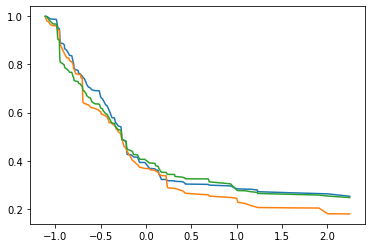

In [383]:
## Plot the survival function for the three first patients in the testing subset

# Plot the survival function of the three first participants in the test subset


prediction1=estimator.predict_survival_function(X_1.iloc[:4])[0]
prediction2=estimator.predict_survival_function(X_1.iloc[:4])[1]
prediction3=estimator.predict_survival_function(X_1.iloc[:4])[2]
# YOUR CODES GO HERE
plt.plot(prediction1.x,prediction1.y)
plt.plot(prediction2.x,prediction2.y)
plt.plot(prediction3.x,prediction3.y)
plt.show()

As you can observe, these functions are not proportional. Their shape depends on the predictor variables of each patient.

**TASK 16:**
Please answer the questions below [4 POINTS]:

In TASK 4, we split the dataset into two seperate sets for training (80%) and testing (20%). Considering the size of the dataset we use in this lab, do you think this split is a good choice？ Would you recommend a different method to train and validate models?

I would recommend using K-fold validation or leave-one-out validation since we only have limited and unbalanced data.

**BONUS TASK:** 

Using the decision tree code that you created in Lab 2 as a base, create your own Survival Tree algorithm, using the splitting criterion of your choice (you can use Logrank statistic or likelihood ratio statistic, as indicated in the course's slides). The algorithm should include the same hyper-parameters from Lab2 and also min_obs_leaf, which indicates the minimum number of observations that a leaf should have. Use the training subset to train a survival tree and represent the survival functions on the three first patients from the testing subset. (12 points)





In [ ]:
# YOUR CODES GO HERE

**TASK 17:** Execute the following cell to finish the lab (1 POINT)

In [ ]:
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/WwJPoL5FLF8" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')


**Congratulations!! You have finished Lab 3!!**